### In this notebook we solve benchmark problms that given in libCEED in 2D with assmbled and matrix-free approaches. 

In [1]:
using Plots
using LinearAlgebra
using SparseArrays
using FastGaussQuadrature
using NLsolve
using Random
using DataFrames
using Test

In [2]:
default(linewidth=3)
function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(30 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end

my_spy (generic function with 1 method)

In [3]:
function vander_legendre_deriv(x, k=nothing)
    if isnothing(k)
        k = length(x) # Square matrix by default
    end
    m = length(x)
    Q = ones(m, k)
    dQ = zeros(m, k)
    Q[:, 2] = x
    dQ[:, 2] .= 1
    for n in 1:k-2
        Q[:, n+2] = ((2*n + 1) * x .* Q[:, n+1] - n * Q[:, n]) / (n + 1)
        dQ[:, n+2] = (2*n + 1) * Q[:,n+1] + dQ[:,n]
    end
    Q, dQ
end

function febasis1D(P, Q, Qmode)
    x, _ = gausslobatto(P)
    if Qmode == "GAUSS"
        q, w = gausslegendre(Q)
    elseif Qmode == "GLL"
        q, w = gausslobatto(Q)
    else
        error("Qmode error! Choose GAUSS or GLL Quadrature points!");
    end
    V, _ = vander_legendre_deriv(x)
    Bp, Dp = vander_legendre_deriv(q, P)
    B = Bp / V
    D = Dp / V
    x, q, w, B, D
end

meshgrid(x, y) = (repeat(x, outer=length(y)), repeat(y, inner=length(x)))

function febasis2D(P, Q, num_comp, Qmode)
    # coordinate, quadrature, and basis on reference element [-1,1]
    x1_ref, q1_ref, w1_ref, B1, D1 = febasis1D(P, Q, Qmode)
    
    x, y = meshgrid(x1_ref, x1_ref)
    x2_ref = [x;y]
    qx, qy = meshgrid(q1_ref, q1_ref)
    q2_ref = [qx;qy]
    w2_ref = kron(w1_ref, w1_ref)
    
    B2 = kron(I(num_comp),kron(B1,B1))
    Dx = kron(B1, D1)
    Dy = kron(D1, B1)
    # Grad for num_comp = 1
    Dx = kron([1, 0], Dx)
    Dy = kron([0, 1], Dy)
    D2 = Dx + Dy
    D2 = kron(I(num_comp),D2)
    
    x2_ref, q2_ref, w2_ref, B2, D2
end

struct FEBasis
    P::Int
    Q::Int
    num_comp::Int
    Qmode::String
    x_ref::Vector  # nodes at 2D ref element
    q_ref::Vector  # quad pts for 2D ref element
    w_ref::Vector  # weights for 2D ref element
    B::Matrix  # Interpolation
    D::Matrix  # Derivative
    function FEBasis(P, Q, num_comp, Qmode)
        x_ref, q_ref, w_ref, B, D = febasis2D(P, Q, num_comp, Qmode)
        
        new(P, Q, num_comp, Qmode, x_ref, q_ref, w_ref, B, D)
    end
end

# <font color='red'> Assembled approach
## $L^2$ projection and Poisson problem
Find $u \in \mathcal V_h$ such that
$$ \int_{\Omega} v(x) \big[ u(x) - f(x) \big] = 0, \quad \forall v \in \mathcal V_h$$

$$ \int_{\Omega} \nabla v \cdot \kappa \cdot \nabla u = \int_{\Omega} v f, \forall v$$

In [4]:
function GetConnectivity(P, nx, ny)
    """This function returns the connectivity array

    4-------5--------6
    |       |        |
    |       |        |
    |       |        |
    1-------2--------3
    local numbering of one element is

    3-------4
    |       |
    |       |
    |       |
    1-------2


    Input:
    ------
    P: number of node in 1D, so for quad linear element P=2
    nx: number of element in x direction start from 1
    ny: number of element in y direction start from 1
    Output:
    ------
    idx: connectivity index of size (num_elem x P*P) based on above node numbering
    idx_bc: index for 4 faces to apply bc: [bottom, right, top, left]
    """
    n_elems = [nx, ny]
    nodes_u = zeros(Int64, 2)
    nodes_x = zeros(Int64, 2)
    for d=1:2
        nodes_u[d] = n_elems[d]*(P-1) + 1
        nodes_x[d] = n_elems[d]*(2-1) + 1
    end

    num_elem = n_elems[1] * n_elems[2]
    idx_x = zeros(Int64, 4, num_elem) # Coordinate connectivity
    idx_u = zeros(Int64, P * P, num_elem) # Solution connectivity
    for i=1:n_elems[1]
        for j=1:n_elems[2]
            ele = (j-1)*n_elems[1] + i
            for ii=1:P
                for jj=1:P
                    if (ii < 3) && (jj < 3)
                        idx_x[(ii-1) * 2 + jj, ele] = ((j-1) * (2 - 1) + ii-1) * nodes_x[1] + (i-1) * (2 - 1) + jj
                    end
                    idx_u[(ii-1) * P + jj, ele] = ((j-1) * (P - 1) + ii-1) * nodes_u[1] + (i-1) * (P - 1) + jj
                end
            end
        end
    end
    
    idx_b = Int64[] # bottom face
    idx_t = Int64[] # top face
    for i=1:n_elems[1]
        if i==1
            append!(idx_b, idx_u[1:P,i])
            append!(idx_t, idx_u[P*(P-1)+1:P*P,i + n_elems[1]*(n_elems[2] -1)])
        else
            append!(idx_b, idx_u[2:P,i])
            append!(idx_t, idx_u[P*(P-1)+2:P*P,i + n_elems[1]*(n_elems[2] -1)])
        end
    end

    idx_l = Int64[] # left face
    idx_r = Int64[] # right face
    for i=1:n_elems[1]:num_elem
        if i==1
            append!(idx_l, idx_u[1:P:P*(P-1)+1,i])
            append!(idx_r, idx_u[P:P:P*P,i+n_elems[1]-1])
        else
            append!(idx_l, idx_u[P+1:P:P*(P-1)+1,i])
            append!(idx_r, idx_u[2*P:P:P*P,i+n_elems[1]-1])
        end
    end
    
    return idx_x, idx_u, idx_b, idx_r, idx_t, idx_l, nodes_u
end


struct FEIndices
    P::Int
    nx::Int
    ny::Int
    idx_x::Matrix
    idx_u::Matrix
    idx_b::Vector
    idx_r::Vector
    idx_t::Vector
    idx_l::Vector
    nodes_u::Vector
    Er_x::Vector
    Er_u::Vector
    function FEIndices(P, num_comp, nx, ny)
        idx_x, idx_u, idx_b, idx_r, idx_t, idx_l, nodes_u = GetConnectivity(P, nx, ny)
        
        # number of nodes
        dof_u = maximum(idx_u)
        dof_x = maximum(idx_x)
        # element dof
        elem_dof_u = size(idx_u, 1)
        elem_dof_x = size(idx_x, 1)
        num_elem = size(idx_x, 2)
        # element restriction operator
        Er_x = []
        Er_u = []
        for e = 1:num_elem
            Lx = spzeros(Int64, elem_dof_x, dof_x)
            Lu = spzeros(Int64, elem_dof_u, dof_u)
            for i=1:elem_dof_u
                if i < elem_dof_x + 1
                    Lx[i, idx_x[i, e] ] = 1
                end
                Lu[i, idx_u[i, e] ] = 1
            end
            Lx = kron(I(2), Lx)
            Lu = kron(I(num_comp), Lu)
            push!(Er_x, Lx)
            push!(Er_u, Lu)
        end
        
        new(P, nx, ny, idx_x, idx_u, idx_b, idx_r, idx_t, idx_l, nodes_u, Er_x, Er_u)
    end
end

In [5]:
function GetCoordNodes(mesh, nelx, nely, aspect_ratio)
    """ This function returns the physical coordinates of the nodes.
    Input:
    ------
    nelx:   integer
            number of elements in the x direction.
    nely:   integer
            number of elements in the y direction.
    mesh: can be unifrom or nonuniform

    Output:
    -------
    x:      float (1d array)
            the coordinate of the node in the x direction
    y:      float (1d array)
            the coordinate of the node in the y direction
    The geometry we are working on is like the following.
    (for nelx = 2, nely = 2)
    6---------7----------8
    |         |   (3)    |
    |   (2)   |      ----5
    |      ---4-----/    |
    3-----/   |   (1)    |
    |         |      ----2
    |   (0)   |     /
    |     ----1----/
    0----/
    There are 4 elements (numbering in parenthesis), and 9 nodes.
    This function returns x,y as 9x2 array for the above mesh.
    """
    nodex = nelx + 1
    nodey = nely + 1
    numnodes = nodex*nodey
    # interior nodes for random mesh
    interiornodex = nelx - 1
    interiornodey = nely - 1
    interiornodes = interiornodex*interiornodey

    hx = 1/nelx
    hy = 1/(nely*aspect_ratio)
    h = minimum([hx hy])
    
    if (aspect_ratio <1)
        error!("aspect_ratio must be bigger than 1")
    end

    # Divide [0,1] by nodex (mesh in the x direction)
    x0 = LinRange(0, 1, nodex)
    if mesh == "uniform"
        y0 = 0.0*x0 # the bottom geometry line  
        y = zeros(numnodes, 1)
        for i=1:nodex
            # Divide [0,1] by nodey (mesh in the y direction)
            y1 = LinRange(y0[i], 1/aspect_ratio, nodey)
            for j=1:nodey
                y[i + (j-1)*nodex] = y1[j]   # collection of y
            end
        end
        x = zeros(numnodes, 1)
        for i=1:nodey
            for j=1:nodex
                x[j + (i-1)*nodex] = x0[j]   # collection of x
            end
        end

    elseif mesh == "random"
        y0 = 0.0*x0 # the bottom geometry line  
        y = zeros(numnodes, 1)
        for i=1:nodex
            # Divide [0,1] by nodey (mesh in the y direction)
            y1 = LinRange(y0[i], 1/aspect_ratio, nodey)
            for j=1:nodey
                y[i + (j-1)*nodex] = y1[j]   # collection of y
            end
        end
        x = zeros(numnodes, 1)
        for i=1:nodey
            for j=1:nodex
                x[j + (i-1)*nodex] = x0[j]   # collection of x
            end
        end
        Random.seed!(1234)
        randnodes_x = rand(interiornodes,1)*hx/2 .- hx/4
        randnodes_y = rand(interiornodes,1)*hy/2 .- hy/4
        # perturb the (x,y) of interior nodes
        for i=1:interiornodey
            for j=1:interiornodex
                x[i*(nodex) + j+1] = x[i*(nodex) + j+1] - randnodes_x[j+(i-1)*interiornodex]
                y[i*(nodex) + j+1] = y[i*(nodex) + j+1] - randnodes_y[j+(i-1)*interiornodex]
            end
        end
        
    elseif mesh == "trapezoid"
        y0 = 0.0*x0 # the bottom geometry line  
        y = zeros(numnodes, 1)
        for i=1:nodex
            # Divide [0,1] by nodey (mesh in the y direction)
            y1 = LinRange(y0[i], 1, nodey)
            for j=1:nodey
                y[i + (j-1)*nodex] = y1[j]   # collection of y
            end
        end
        x = zeros(numnodes, 1)
        for i=1:nodey
            for j=1:nodex
                x[j + (i-1)*nodex] = x0[j]   # collection of x
            end
        end
        # perturb the (x,y) of interior nodes
        for i=1:interiornodey
            for j=1:interiornodex
                #x[i*(nodex) + j+1] = x[i*(nodex) + j+1] - randnodes[j+(i-1)*interiornodex]
                y[i*(nodex) + j+1] = y[i*(nodex) + j+1] - (-1)^j *(h/4)
            end
        end

    else
        error("Enter one of the mesh option: 'unifrom', 'trapezoid', 'random' ")
    end
    
    #
    return x, y

end

function plotmesh(mesh, xn, yn, idx_x)

    p = plot()
    nodes = [1 2 4 3 1]
    xx = zeros(5,1)
    yy = zeros(5,1)
    num_elem = size(idx_x, 2)
    for i = 1:num_elem
        for j =1:5
        xx[j] = xn[idx_x[nodes[j],i]] 
        yy[j] = yn[idx_x[nodes[j],i]] 
        end
        plot!(p,xx,yy,color="black",legend=false)
    end
    
    return p
end

function GetCoordElem(xn, yn, Er_x, e)
    """
    This functions returns coordinate of element "E"
    Input:
    x,y,z: coordinate of all nodes of a mesh
    IENn: connectivity of nodes
    
    Return:
    coord_E: coordinate of element e as a (8,1) array
    which is [x;y] coordinates of the 4 nodes
    """
    
    return Er_x[e]*[xn; yn]
end

GetCoordElem (generic function with 1 method)

In [6]:
function GetQdata(Coord_E, Bx::FEBasis)
    J1 = Bx.D*Coord_E
    J2 = reshape(J1, Bx.Q^2, :)
    J = zeros(Bx.Q^2, 2, 2)
    detJ = zeros(Bx.Q^2)
    dXdx_T = zeros(Bx.Q^2, 2, 2)
    for i=1:Bx.Q^2
        J[i,:,:] = reshape(J2[i,:], 2, 2)
        detJ[i] = det(J[i,:,:])
        dXdx_T[i,:,:] = I/J[i,:,:]
    end
    
    # quadrature pts in elmenet E
    q = Bx.B * Coord_E
    
    wdetJ = Bx.w_ref .* detJ;
    
    return q, wdetJ, dXdx_T
end

function GetMassLocal(wdetJ, Bu::FEBasis)
    
    W2 = diagm(wdetJ);
    if Bu.num_comp == 2
        W2 = diagm([wdetJ; wdetJ])
    end
    Me = Bu.B' * W2 * Bu.B
    return Me
end

function GetRhsLocal(wdetJ, q, f, Bu::FEBasis)
    
    W2 = diagm(wdetJ);
    if Bu.num_comp == 2
        W2 = diagm([wdetJ; wdetJ])
    end
    xq = reshape(q, Bu.Q^2,:)
    Fe = Bu.B' * W2 * f(xq[:,1], xq[:,2])  # v^T * f
    return Fe
end

function GetStiffnessLocal(wdetJ, dXdx_T, Bu::FEBasis)
    
    W2 = diagm([wdetJ; wdetJ]);
    if Bu.num_comp == 2
        W2 = diagm([wdetJ; wdetJ; wdetJ; wdetJ]);
    end

    Dd = zeros(2 * Bu.num_comp * Bu.Q^2, size(Bu.D,2))
    for c=1:Bu.num_comp
        for i=1:Bu.Q^2
            D1 = zeros(2, size(Bu.D,2));
            D1[1,:] = Bu.D[i + 2*(c-1)*Bu.Q^2,:]
            D1[2,:] = Bu.D[i + (2*(c-1)+1)*Bu.Q^2,:]
            grad_u1 = dXdx_T[i,:,:] * D1
            DD1 = dXdx_T[i,:,:]' * grad_u1

            Dd[i + 2*(c-1)*Bu.Q^2,:] = DD1[1,:]
            Dd[i + (2*(c-1)+1)*Bu.Q^2,:] = DD1[2,:]
        end
    end
    
    Ke = Bu.D' * W2 * Dd  # grad(v)^T * grad(u)
    
    return Ke
end

function GetFEProjection(xn, yn, Ind::FEIndices, Bx::FEBasis, Bu::FEBasis, f)
    
    num_elem = size(Ind.idx_u,2)
    global_dof = maximum(Ind.idx_u)
    F = spzeros(num_comp*global_dof, 1)
    M = spzeros(num_comp*global_dof,num_comp*global_dof)
    
    for e=1:num_elem
        # Get coordinate of each element
        Coord_E = GetCoordElem(xn, yn, Ind.Er_x, e);
        # Update quadrature
        q, wdetJ, _ = GetQdata(Coord_E, Bx);

        Me = GetMassLocal(wdetJ, Bu);  # v^T * u
        Fe = GetRhsLocal(wdetJ, q, f, Bu);  # v^T * f

        # Assemble
        M = M + Ind.Er_u[e]' * Me * Ind.Er_u[e]
        F = F + Ind.Er_u[e]' * Fe

    end
    u = M \ F
    
   return u 
end

function GetDirichletBCsIndex(num_comp, Ind::FEIndices)
    num_nodes = Ind.nodes_u[1] * Ind.nodes_u[2]
    bc_idx = Int64[]
    for c=0:num_comp -1
        # bottom
        for i=1:Ind.nodes_u[1]
            append!(bc_idx, Ind.idx_b[i] .+ c * num_nodes)
        end
        # right
        for j=1:Ind.nodes_u[2]
            append!(bc_idx, Ind.idx_r[j] .+ c * num_nodes)
        end
        # top
        for i=1:Ind.nodes_u[1]
            append!(bc_idx, Ind.idx_t[i] .+ c * num_nodes)
        end
        # left
        for j=1:Ind.nodes_u[2]
            append!(bc_idx, Ind.idx_l[j] .+ c * num_nodes)
        end
    end
    
    return bc_idx
end


function GetFEPoisson(xn, yn, Ind::FEIndices, Bx::FEBasis, Bu::FEBasis, f)

    num_elem = size(Ind.idx_u,2)
    global_dof = maximum(Ind.idx_u)
    F = spzeros(Bu.num_comp*global_dof, 1)
    K = spzeros(Bu.num_comp*global_dof,Bu.num_comp*global_dof)
    
    for e=1:num_elem
        # Get coordinate of each element
        Coord_E = GetCoordElem(xn, yn, Ind.Er_x, e);
        # Update quadrature
        q, wdetJ, dXdx_T = GetQdata(Coord_E, Bx);
        
        Ke = GetStiffnessLocal(wdetJ, dXdx_T, Bu)
        Fe = GetRhsLocal(wdetJ, q, f, Bu);  # v^T * f

        # Assemble
        K = K + Ind.Er_u[e]' * Ke * Ind.Er_u[e]
        #K = sparse(K)
        F = F + Ind.Er_u[e]' * Fe

    end   
    # Apply Dirichlet BCs
    bc_idx = GetDirichletBCsIndex(Bu.num_comp, Ind);
    F[bc_idx].= 0
    K[bc_idx,:] .= 0.
    for i=1:length(bc_idx)
        K[bc_idx[i], bc_idx[i]] = 1.
    end
    
    u = K \ F
    
   return u 
end

function GetL2Error(xn, yn, Ind::FEIndices, Bx::FEBasis, Bu::FEBasis, uh, uex)
    """This function returns L2 error 
    (sum_{e=1:num_elem} (int_e (uh - uex)^2 dx) )^0.5 
    """

    num_elem = size(Ind.idx_u,2)

    e_u = zeros(num_elem)
    for e=1:num_elem
        # Get coordinate of each element
        Coord_E = GetCoordElem(xn, yn, Ind.Er_x, e);
        # Update quadrature
        q, wdetJ, _ = GetQdata(Coord_E, Bx);

        if num_comp == 2
            wdetJ = [wdetJ; wdetJ]
        end
        
        # dh is the nodal value for element e
        dh = Ind.Er_u[e] * uh
        # Compute uh(x) in quadrature x=q in L2 space 
        u_num = Bu.B * dh
        
        xq = reshape(q, Q^2,:)
        u_ex = uex(xq[:,1], xq[:,2]) 

        err_u = vec((u_num - u_ex))
        # \int (u_num - u_ex)^2 dx ==> on element e
        e_u[e] = wdetJ' * (err_u .* err_u)

    end

    return sqrt(sum(e_u))
end

GetL2Error (generic function with 1 method)

In [7]:
P, num_comp, Qmode = 2, 2, "GAUSS"
Q = P
Bx = FEBasis(2, Q, 2, Qmode);
Bu = FEBasis(P, Q, num_comp, Qmode);
nx, ny, mesh, aspect_ratio = 2, 2, "random", 1
xn, yn = GetCoordNodes(mesh, nx, ny, aspect_ratio);
Ind = FEIndices(P, num_comp, nx, ny);

uex(x, y) = @. sin(pi*x)*sin(pi*y);
f(x, y) = @. 2*pi^2*sin(pi*x)*sin(pi*y);

if num_comp == 2
    function uex(x, y)
        ux = @. sin(pi*x)*sin(pi*y)
        uy = @. 2*sin(pi*x)*sin(pi*y) 
        return [ux; uy]
    end

    function f(x, y)
        fx = @. 2*pi^2 * sin(pi*x)*sin(pi*y)
        fy = @. 4*pi^2 * sin(pi*x)*sin(pi*y) 
        return [fx; fy]
    end
    
end

uh1 = GetFEProjection(xn, yn, Ind, Bx, Bu, uex);
uh2 = GetFEPoisson(xn, yn, Ind, Bx, Bu, f);
L2_error = GetL2Error(xn, yn, Ind, Bx, Bu, uh2, uex)

0.23318860704321684

# <font color='red'> Matrix-Free approach


In [8]:
# This is like libCEED/Ratel Residual Qfunction
function Compute_f0(Q, num_comp, wdetJ, q, uq, f)
    W2 = diagm(wdetJ);
    if num_comp == 2
        W2 = diagm([wdetJ; wdetJ])
    end
    xq = reshape(q, Q^2,:)
    W2 * (uq - f(xq[:,1], xq[:,2]))
end

function Compute_f1(Q, num_comp, wdetJ, dXdx_T, q, Duq)
    W2 = diagm([wdetJ; wdetJ]);
    if num_comp == 2
        W2 = diagm([wdetJ; wdetJ; wdetJ; wdetJ]);
    end

    Dd = zeros(2 * num_comp * Q^2)
    for c=1:num_comp
        for i=1:Q^2
            grad_u1 = dXdx_T[i,:,:] * [Duq[i + 2*(c-1)*Q^2], Duq[i + (2*(c-1)+1)*Q^2]]
            DD1 = dXdx_T[i,:,:]' * grad_u1

            Dd[i + 2*(c-1)*Q^2] = DD1[1]
            Dd[i + (2*(c-1)+1)*Q^2] = DD1[2]
        end
    end
    
    W2 * Dd
end

function Compute_df0(Q, num_comp, wdetJ, q, uq, du, f)
    W2 = diagm(wdetJ);
    if num_comp == 2
        W2 = diagm([wdetJ; wdetJ])
    end
    W2 * du
end

function Compute_df1(Q, num_comp, wdetJ, dXdx_T, q, Duq, Ddu)
    W2 = diagm([wdetJ; wdetJ]);
    if num_comp == 2
        W2 = diagm([wdetJ; wdetJ; wdetJ; wdetJ]);
    end

    Dd = zeros(2 * num_comp * Q^2)
    for c=1:num_comp
        for i=1:Q^2
            grad_du1 = dXdx_T[i,:,:] * [Ddu[i + 2*(c-1)*Q^2], Ddu[i + (2*(c-1)+1)*Q^2]]
            DD1 = dXdx_T[i,:,:]' * grad_du1

            Dd[i + 2*(c-1)*Q^2] = DD1[1]
            Dd[i + (2*(c-1)+1)*Q^2] = DD1[2]
        end
    end
    
    W2 * Dd
end

Compute_df1 (generic function with 1 method)

In [9]:
function ProjectionResidual(u_in, xn, yn, Ind::FEIndices, Bx::FEBasis, Bu::FEBasis, f)
    u = copy(u_in); v = zero(u)
    bc_idx = GetDirichletBCsIndex(Bu.num_comp, Ind)
    u[bc_idx] .= 0

    num_elem = size(Ind.idx_u,2)
    
    for e=1:num_elem
        # Get coordinate of each element
        Coord_E = GetCoordElem(xn, yn, Ind.Er_x, e);
        # Update quadrature
        q, wdetJ, _ = GetQdata(Coord_E, Bx);

        ue = Ind.Er_u[e] * u
        uq = Bu.B * ue

        f0 = Compute_f0(Bu.Q, Bu.num_comp, wdetJ, q, uq, f)
        ve = Bu.B' * f0
        v += sparse(Ind.Er_u[e]') * ve
    
    end
    v[bc_idx] = u_in[bc_idx] - u[bc_idx]
    v

end

function PoissonResidual(u_in, xn, yn, Ind::FEIndices, Bx::FEBasis, Bu::FEBasis, f)

    u = copy(u_in); v = zero(u)
    bc_idx = GetDirichletBCsIndex(Bu.num_comp, Ind)
    u[bc_idx] .= 0
    
    num_elem = size(Ind.idx_u,2)
    
    for e=1:num_elem
        # Get coordinate of each element
        Coord_E = GetCoordElem(xn, yn, Ind.Er_x, e);
        # Update quadrature
        q, wdetJ, dXdx_T = GetQdata(Coord_E, Bx);
        
        ue = Ind.Er_u[e] * u
        uq = 0 * Bu.B * ue
        Duq = Bu.D * ue
        
        f0 = Compute_f0(Bu.Q, Bu.num_comp, wdetJ, q, uq, f)
        f1 = Compute_f1(Bu.Q, Bu.num_comp, wdetJ, dXdx_T, q, Duq)
        ve = Bu.B' * f0 + Bu.D' * f1
        v += sparse(Ind.Er_u[e]') * ve
    end   
    v[bc_idx] = u_in[bc_idx] - u[bc_idx]
    v

end

PoissonResidual (generic function with 1 method)

In [10]:
function ProjectionJacobian(u_in, xn, yn, Ind::FEIndices, Bx::FEBasis, Bu::FEBasis, f)
    u = copy(u_in); 
    bc_idx = GetDirichletBCsIndex(Bu.num_comp, Ind)
    u[bc_idx] .= 0;

    num_elem = size(Ind.idx_u,2)
    rows, cols, vals = Int[], Int[], Float64[]
    for e=1:num_elem
        # Get coordinate of each element
        Coord_E = GetCoordElem(xn, yn, Ind.Er_x, e);
        # Update quadrature
        q, wdetJ, _ = GetQdata(Coord_E, Bx);

        ue = Ind.Er_u[e] * u
        uq = Bu.B * ue
        Jac = zeros(Bu.num_comp * Bu.P * Bu.P, Bu.num_comp * Bu.P * Bu.P);
        for c=0:Bu.num_comp-1
            for j=1:Bu.P * Bu.P
                du = Bu.B[:,j + c*Bu.P * Bu.P]
                df0 = Compute_df0(Bu.Q, Bu.num_comp, wdetJ, q, uq, du, f)
                Jac[:,j + c*Bu.P * Bu.P] = Bu.B' * df0
            end
        end
        inds = rowvals(sparse(Ind.Er_u[e]'))
        append!(rows, kron(ones(Bu.num_comp * Bu.P * Bu.P), inds))
        append!(cols, kron(inds, ones(Bu.num_comp * Bu.P * Bu.P)))
        append!(vals, vec(Jac))
    end
    A = sparse(rows, cols, vals)
    A[bc_idx,:] .= 0.; A[:, bc_idx] .= 0.
    for i=1:length(bc_idx)
        A[bc_idx[i], bc_idx[i]] = 1.
    end
    A
end
    

function PoissonJacobian(u_in, xn, yn, Ind::FEIndices, Bx::FEBasis, Bu::FEBasis, f)

    u = copy(u_in);
    bc_idx = GetDirichletBCsIndex(Bu.num_comp, Ind)
    u[bc_idx] .= 0
    
    num_elem = size(Ind.idx_u,2)
    rows, cols, vals = Int[], Int[], Float64[]
    for e=1:num_elem
        # Get coordinate of each element
        Coord_E = GetCoordElem(xn, yn, Ind.Er_x, e);
        # Update quadrature
        q, wdetJ, dXdx_T = GetQdata(Coord_E, Bx);
        
        ue = Ind.Er_u[e] * u
        Duq = Bu.D * ue
        Jac = zeros(Bu.num_comp * Bu.P * Bu.P, Bu.num_comp * Bu.P * Bu.P);
        for c=0:Bu.num_comp-1
            for j=1:Bu.P * Bu.P
                Ddu = Bu.D[:,j + c*Bu.P * Bu.P]
                df1 = Compute_df1(Bu.Q, Bu.num_comp, wdetJ, dXdx_T, q, Duq, Ddu)
                Jac[:,j + c*Bu.P * Bu.P] = Bu.D' * df1
            end
        end
        inds = rowvals(sparse(Ind.Er_u[e]'))
        append!(rows, kron(ones(Bu.num_comp * Bu.P * Bu.P), inds))
        append!(cols, kron(inds, ones(Bu.num_comp * Bu.P * Bu.P)))
        append!(vals, vec(Jac))
    end   
    A = sparse(rows, cols, vals)
    A[bc_idx,:] .= 0.; A[:, bc_idx] .= 0.
    for i=1:length(bc_idx)
        A[bc_idx[i], bc_idx[i]] = 1.
    end
    A

end

PoissonJacobian (generic function with 1 method)

In [11]:
global_dof = maximum(Ind.idx_u)
u_dof = Bu.num_comp*global_dof;
u0 = zeros(u_dof)
uh_proj = nlsolve(u -> ProjectionResidual(u, xn, yn, Ind, Bx, Bu, uex),
                  u -> ProjectionJacobian(u, xn, yn, Ind, Bx, Bu, uex), u0; method = :newton);
uh_pois = nlsolve(u -> PoissonResidual(u, xn, yn, Ind, Bx, Bu, f),
                  u -> PoissonJacobian(u, xn, yn, Ind, Bx, Bu, f), u0; method = :newton);
L2_error_proj = GetL2Error(xn, yn, Ind, Bx, Bu, uh_proj.zero, uex)
L2_error_pois = GetL2Error(xn, yn, Ind, Bx, Bu, uh_pois.zero, uex)

0.23318860704321684

# <font color='blue'> Convergence study: Assembled 

In [12]:
P, num_comp, Qmode = 2, 2, "GAUSS"
Q = P
Bx = FEBasis(2, Q, 2, Qmode);
Bu = FEBasis(P, Q, num_comp, Qmode);
nx, ny, mesh, aspect_ratio = 2, 2, "random", 1
xn, yn = GetCoordNodes(mesh, nx, ny, aspect_ratio);
Ind = FEIndices(P, num_comp, nx, ny);

In [13]:
N = 5
res = 4 .*(1:N)
eu_proj = zeros(N)
eu_pois = zeros(N)
order_u_proj = []
order_u_pois = []
append!(order_u_proj, 0)
append!(order_u_pois, 0)
H = zeros(N)
# refinement to plot convergence order
for i=1:N

    nx = res[i]
    ny = res[i]

    xn, yn = GetCoordNodes(mesh, nx, ny, aspect_ratio);
    Ind = FEIndices(P, num_comp, nx, ny);
    uh_proj = GetFEProjection(xn, yn, Ind, Bx, Bu, uex);
    uh_pois = GetFEPoisson(xn, yn, Ind, Bx, Bu, f);
    L2_error_proj = GetL2Error(xn, yn, Ind, Bx, Bu, uh_proj, uex)
    L2_error_pois = GetL2Error(xn, yn, Ind, Bx, Bu, uh_pois, uex)
    
    eu_proj[i] = L2_error_proj
    eu_pois[i] = L2_error_pois
    
    #h = Gethsz(xn, yn, IEN)
    H[i] = 1/nx

    if (i > 1)
        logH = log10(H[i]/H[i-1])
        append!(order_u_proj, log10(eu_proj[i]/eu_proj[i-1])/logH)
        append!(order_u_pois, log10(eu_pois[i]/eu_pois[i-1])/logH)
    end
end

In [14]:
# P is number of nodes/elem in 1D, convergence order should be "P", It might be super-convergent
df = DataFrame("N" => res, "Projection Error" => eu_proj, "Order u (Projection)" => order_u_proj,
"Poisson Error" => eu_pois, "Order u (Poisson)" => order_u_pois)
println("***********************************************************************\n")
println("Convergence study (Assembled) for $mesh mesh, number of component:$num_comp, and P:$P \n")
println("***********************************************************************\n")
println(df)

***********************************************************************

Convergence study (Assembled) for random mesh, number of component:2, and P:2 

***********************************************************************

5×5 DataFrame
 Row │ N      Projection Error  Order u (Projection)  Poisson Error  Order u (Poisson) 
     │ Int64  Float64           Any                   Float64        Any               
─────┼─────────────────────────────────────────────────────────────────────────────────
   1 │     4        0.0233399   0                        0.0759941   0
   2 │     8        0.0081397   1.51975                  0.021869    1.797
   3 │    12        0.00327711  2.24382                  0.00955976  2.04088
   4 │    16        0.00178548  2.11091                  0.00520393  2.11396
   5 │    20        0.00101866  2.515                    0.00320437  2.17304


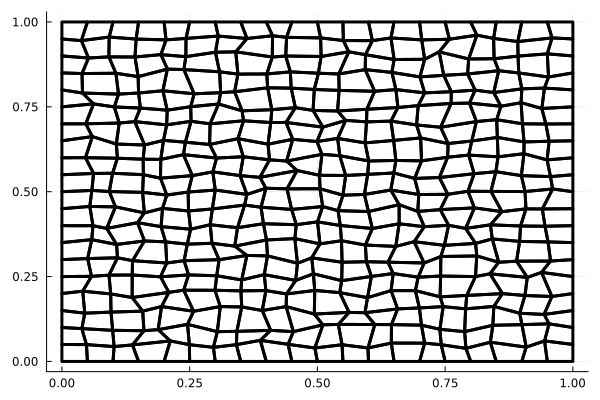

In [15]:
plotmesh(mesh, xn, yn, Ind.idx_x)

# <font color='blue'> Convergence study: Matrix-Free 

In [16]:
N = 5
res = 4 .*(1:N)
eu_proj = zeros(N)
eu_pois = zeros(N)
order_u_proj = []
order_u_pois = []
append!(order_u_proj, 0)
append!(order_u_pois, 0)
H = zeros(N)
# refinement to plot convergence order
for i=1:N

    nx = res[i]
    ny = res[i]

    xn, yn = GetCoordNodes(mesh, nx, ny, aspect_ratio);
    Ind = FEIndices(P, num_comp, nx, ny);
    global_dof = maximum(Ind.idx_u)
    u_dof = Bu.num_comp*global_dof;
    u0 = zeros(u_dof)
    uh_proj = nlsolve(u -> ProjectionResidual(u, xn, yn, Ind, Bx, Bu, uex),
                  u -> ProjectionJacobian(u, xn, yn, Ind, Bx, Bu, uex), u0; method = :newton);
    uh_pois = nlsolve(u -> PoissonResidual(u, xn, yn, Ind, Bx, Bu, f),
                  u -> PoissonJacobian(u, xn, yn, Ind, Bx, Bu, f), u0; method = :newton);
    L2_error_proj = GetL2Error(xn, yn, Ind, Bx, Bu, uh_proj.zero, uex)
    L2_error_pois = GetL2Error(xn, yn, Ind, Bx, Bu, uh_pois.zero, uex)
    
    eu_proj[i] = L2_error_proj
    eu_pois[i] = L2_error_pois
    
    #h = Gethsz(xn, yn, IEN)
    H[i] = 1/nx

    if (i > 1)
        logH = log10(H[i]/H[i-1])
        append!(order_u_proj, log10(eu_proj[i]/eu_proj[i-1])/logH)
        append!(order_u_pois, log10(eu_pois[i]/eu_pois[i-1])/logH)
    end
end

In [17]:
# P is number of nodes/elem in 1D, convergence order should be "P", It might be super-convergent
df = DataFrame("N" => res, "Projection Error" => eu_proj, "Order u (Projection)" => order_u_proj,
"Poisson Error" => eu_pois, "Order u (Poisson)" => order_u_pois)
println("***********************************************************************\n")
println("Convergence study (Matrix-Free) for $mesh mesh, number of component:$num_comp, and P:$P \n")
println("***********************************************************************\n")
println(df)

***********************************************************************

Convergence study (Matrix-Free) for random mesh, number of component:2, and P:2 

***********************************************************************

5×5 DataFrame
 Row │ N      Projection Error  Order u (Projection)  Poisson Error  Order u (Poisson) 
     │ Int64  Float64           Any                   Float64        Any               
─────┼─────────────────────────────────────────────────────────────────────────────────
   1 │     4        0.0276956   0                        0.0759941   0
   2 │     8        0.00863746  1.68098                  0.021869    1.797
   3 │    12        0.00343756  2.27232                  0.00955976  2.04088
   4 │    16        0.00184966  2.15432                  0.00520393  2.11396
   5 │    20        0.00105868  2.50054                  0.00320437  2.17304


In [18]:
@time GetFEProjection(xn, yn, Ind, Bx, Bu, uex);

  1.761598 seconds (40.42 k allocations: 4.682 GiB, 13.53% gc time)


In [19]:
@time GetFEPoisson(xn, yn, Ind, Bx, Bu, f);

  1.289299 seconds (83.51 k allocations: 4.688 GiB, 14.02% gc time)


In [21]:
global_dof = maximum(Ind.idx_u)
u_dof = Bu.num_comp*global_dof;
u0 = zeros(u_dof);

In [22]:
@time nlsolve(u -> ProjectionResidual(u, xn, yn, Ind, Bx, Bu, uex),
              u -> ProjectionJacobian(u, xn, yn, Ind, Bx, Bu, uex), u0; method = :newton);

  0.086006 seconds (227.33 k allocations: 70.956 MiB, 13.67% gc time, 24.80% compilation time)


In [23]:
@time nlsolve(u -> PoissonResidual(u, xn, yn, Ind, Bx, Bu, f),
              u -> PoissonJacobian(u, xn, yn, Ind, Bx, Bu, f), u0; method = :newton);


  0.132588 seconds (536.11 k allocations: 112.957 MiB, 13.08% gc time, 12.27% compilation time)


In [24]:
# Note to myself: I need to define residual and Jaocbian for assembled approach so I can use nlsolve for both method